# Guión y animaciones 

In [1]:
from manim import *
import numpy as np

config.media_width = "75%"
config.verbosity = "WARNING"

Manim Community v0.16.0.post0

GUIÓN: Presentación del problema

En este video, abordaremos la pregunta sobre cómo un computador puede jugar de manera inteligente un juego contra un oponente. Nos enfocaremos en un tipo de juego en particular, a saber, juegos de suma cero, donde el beneficio que obtiene un jugador por una jugada en particular es en igual medida un costo para el adversario.

In [61]:
%%manim -ql Intuition

class Intuition(Scene):
    def construct(self):
        
        table_scale = 0.3
        
        # Tables
        
        cross = VGroup(
            Line(UP + LEFT, DOWN + RIGHT),
            Line(UP + RIGHT, DOWN + LEFT)).set_color(RED).scale(0.5)
        
        circle = Circle().set_color(BLUE).scale(0.5)
        
        blank = Square().set_color(BLACK).scale(0.5)
        
        base_table = MobjectTable(
            [[blank.copy(), cross.copy(), blank.copy()],
            [cross.copy(), circle.copy(), circle.copy()],
            [cross.copy(), blank.copy(), blank.copy()]]
        ).add_background_rectangle(color=BLACK, opacity=1).scale(table_scale).shift(0.5 * DOWN)
        
        first_loss_table = MobjectTable(
            [[blank.copy(), cross.copy(), blank.copy()],
            [cross.copy(), circle.copy(), circle.copy()],
            [cross.copy(), blank.copy(), circle.copy()]]
        ).add_background_rectangle(color=BLACK, opacity=1).scale(table_scale).next_to(base_table, 3 * RIGHT + UP)
        
        tie_table = MobjectTable(
            [[circle.copy(), cross.copy(), blank.copy()],
            [cross.copy(), circle.copy(), circle.copy()],
            [cross.copy(), blank.copy(), blank.copy()]]
        ).add_background_rectangle(color=BLACK, opacity=1).scale(table_scale).next_to(base_table, 3 * RIGHT + DOWN)
        
        l1 = Arrow(base_table.get_right(), first_loss_table.get_left(), stroke_width=2, max_tip_length_to_length_ratio=0.1)
        l2 = Arrow(base_table.get_right(), tie_table.get_left(), stroke_width=2, max_tip_length_to_length_ratio=0.1)
        
        all_tables = VGroup(base_table, first_loss_table, tie_table, l1, l2)
        
        problem_tex = Text("¿Cómo sabemos distinguir entre una jugada buena y otra mala?").scale(0.6).shift(3 * UP)
        
        op_1 = Text("1. Especificar reglas").set_color(WHITE)
        op_2 = Text("2. Anticipar las consecuencias").set_color(WHITE)
        
        options = VGroup(op_1, op_2).arrange(direction=DOWN, aligned_edge=LEFT).scale(0.5).next_to(base_table, 2 * LEFT)
        
        
        # Animations
        
        self.play(FadeIn(problem_tex))
        
        self.play(FadeIn(base_table, runtime=3))

        self.wait()
        
        self.play(FadeIn(first_loss_table), FadeIn(l1), runtime=3)
        
        self.play(FadeIn(tie_table), FadeIn(l2), runtime=3)
        
        self.wait()
        
        self.play(all_tables.animate().shift(RIGHT))
        
        self.play(FadeIn(op_1))
        
        self.wait()
        
        self.play(FadeIn(op_2))
        
        self.wait()
        

GUIÓN: Gato como ejemplo simplificado del problema

Para simplificar el argumento, comenzaremos analizando un juego muy simple: el gato. Se tiene el siguiente estado del juego, y supongamos que somos el jugador de círculos y es nuestro turno. 

Hay dos tipos de jugadas que podemos realizar en esta situación; una como la opción de arriba, donde está abierta la opción de victoria para el oponente, y otra como la opción de abajo, donde bloqueamos la opción de victoria de nuestro adversario. Si bien la mejor opción nos parece evidente en este caso, una pregunta menos obvia es cómo un computador podría saber cual de las dos jugadas es mejor.

Una primera aproximación podría ser considerar reglas específicas para cada situación del juego. En el tablero actual, dado que el jugador de cruces está a un movimiento de la victoria, lo lógico es bloquear dicha opción, de modo que uno de los protocolos de nuestro programa podría ser algo como "Si el oponente tiene una opción de victoria, hay que bloquearla". Considerando las otras posibles situaciones del juego, podríamos instanciar más reglas que nos digan qué hacer en esos casos para construir nuestro agente.

El principal problema con la anterior solución, sin embargo, tiene que ver con la escala. El gato tiene 9 espacios, donde se pierde uno por turno, lo que nos dá un total de 9! = 362.880 posibles juegos. Si bien existen redundancias dentro de estos, aún así tendremos que programar una cantidad considerable de reglas para que nuestro agente juege de manera inteligente, y eso para uno de los juegos más simples. Si quisieramos luego programar algún agente que juegue ajedrez (donde tenemos 10^40 juegos posibles), considerar de manera explícita las reglas se vuelve infactible, de modo que nuestra solución, además de ser engorrosa, no escala a escenarios de mayor complejidad.

Una aproximación más general a cómo resolver este problema tiene relación con ser capaz de anticipar los resultados de un juego si se realiza una jugada en particular. Para esto, debemos realizar el ejercicio de mirar el juego desde nuestra perspectiva, o desde la perspectiva de nuestro oponente. Este cambio de perspectiva puede explicarse mediante una analogía útil.

Supongamos que estamos jugando con los círculos y es nuestro turno. Imaginemos que tenemos dos jugadores: Max y Min. Max está jugando con los círculos, mientras que Min juega con las cruces, de modo que cualquier jugada buena para Max será buena para nosotros. Nuestra metología para decidir qué hacer será simuar un juego entre Max y Min, y buscar la jugada que sea más beneficiosa para Max.


GUIÓN: ¿Cómo determinamos los juegos posibles y el valor de sus resultados finales?

Para anticipar el curso del juego de manera que podamos elegir la mejor jugada, Max tiene que determinar los resultados a los que conducirán las diferentes jugadas que puede realizar. Una vez que tengamos esos estados, queremos encontrar una manera de etiquetar cada uno de estos en base a qué tan beneficiosos son para nosotros. Para hacer esas etiquetas, podemos hacer la siguiente asignación de puntaje:

* Si el estado que estoy viendo es una victoria para Max, asignamos un puntaje de 1
* Si el estado que estoy viendo es una derrota para Max, asignamos un puntaje de -1
* Si el estado que estoy viendo es un empate, asignamos un puntaje de 0

Así, vemos que a Max le interesa realizar la jugada que lleve al estado con el máximo puntaje posible, es decir, Max maximiza el puntaje. Min, en cambio, quiere hacer la jugada que lleve al estado con el menor puntaje posible, es decir, minimiza el puntaje.

Si alguno de los estados sucesores no entra en esas tres categorías, tendremos que simular el turno de Min para saber a qué resultado nos llevará eventualmente esa jugada.Min está igual de interesado que Max en ganar, de modo va a elegir la mejor jugada que tiene disponible. Para encontrar la mejor jugada desde este estado en particular, puede, al igual que Max, buscar los estados a los que conducen cada jugada que tiene disponible, y luego evaluar cada uno de estos en base a si es una victoria, derrota o empate para sí mismo. Como a Min le interesa que Max pierda, su mejor jugada será aquella que lleve al estado con el mínimo puntaje posible.

Si alguno de los estados que mira Min resulta ser no terminal, llegamos a un punto del juego donde nuevamente será el turno de Max, de modo que para evaluar dicho estado, tenemos que tomar otra vez el punto de vista de Max y evaluar los estados sucesores. Si se repite este ciclo de cambiar perspectiva las suficientes veces, llegaremos a un punto donde podremos asignar puntaje a todos los estamos terminales. Luego, la decisión que debe tomar Max será simplemente tomar los caminos azules; la secuencia de decisiones que lleve al mejor resultado posible dentro de los que fueron evaluados.


In [125]:
%%manim -ql MaxPerspective
import networkx as nx

class MaxPerspective(Scene):
    def construct(self):
        
        tree_layout_scale = 6
        table_scale = 0.15
        
        # Tables
        
        # Player tables
        
        cross = VGroup(
            Line(UP + LEFT, DOWN + RIGHT),
            Line(UP + RIGHT, DOWN + LEFT)).set_color(RED).scale(0.5)
        circle = Circle().set_color(BLUE).scale(0.5)
        blank = Circle().set_color(BLACK).scale(0.5)
        
        base_table = MobjectTable(
            [[blank.copy(), cross.copy(), blank.copy()],
            [cross.copy(), circle.copy(), circle.copy()],
            [cross.copy(), blank.copy(), blank.copy()]]
        ).add_background_rectangle(color=BLACK, opacity=1)
        
        first_loss_table = MobjectTable(
            [[blank.copy(), cross.copy(), blank.copy()],
            [cross.copy(), circle.copy(), circle.copy()],
            [cross.copy(), blank.copy(), circle.copy()]]
        ).add_background_rectangle(color=BLACK, opacity=1)
        
        first_loss_table_2 = MobjectTable(
            [[cross.copy(), cross.copy(), blank.copy()],
            [cross.copy(), circle.copy(), circle.copy()],
            [cross.copy(), blank.copy(), circle.copy()]]
        ).add_background_rectangle(color=BLACK, opacity=1)

        second_loss_table = MobjectTable(
            [[blank.copy(), cross.copy(), blank.copy()],
            [cross.copy(), circle.copy(), circle.copy()],
            [cross.copy(), circle.copy(), blank.copy()]]
        ).add_background_rectangle(color=BLACK, opacity=1)
        
        second_loss_table_2 = MobjectTable(
            [[cross.copy(), cross.copy(), blank.copy()],
            [cross.copy(), circle.copy(), circle.copy()],
            [cross.copy(), circle.copy(), blank.copy()]]
        ).add_background_rectangle(color=BLACK, opacity=1)

        third_loss_table = MobjectTable(
            [[blank.copy(), cross.copy(), circle.copy()],
            [cross.copy(), circle.copy(), circle.copy()],
            [cross.copy(), blank.copy(), blank.copy()]]
        ).add_background_rectangle(color=BLACK, opacity=1)
        
        third_loss_table_2 = MobjectTable(
            [[cross.copy(), cross.copy(), circle.copy()],
            [cross.copy(), circle.copy(), circle.copy()],
            [cross.copy(), blank.copy(), blank.copy()]]
        ).add_background_rectangle(color=BLACK, opacity=1)

        tie_table = MobjectTable(
            [[circle.copy(), cross.copy(), blank.copy()],
            [cross.copy(), circle.copy(), circle.copy()],
            [cross.copy(), blank.copy(), blank.copy()]]
        ).add_background_rectangle(color=BLACK, opacity=1)
        
        tie_table_2 = MobjectTable(
            [[circle.copy(), cross.copy(), blank.copy()],
            [cross.copy(), circle.copy(), circle.copy()],
            [cross.copy(), blank.copy(), cross.copy()]]
        ).add_background_rectangle(color=BLACK, opacity=1)
        
        min_loss_table1 = MobjectTable(
            [[blank.copy(), cross.copy(), blank.copy()],
            [cross.copy(), circle.copy(), circle.copy()],
            [cross.copy(), cross.copy(), circle.copy()]]
        ).add_background_rectangle(color=BLACK, opacity=1)
        
        min_loss_table2 = MobjectTable(
            [[blank.copy(), cross.copy(), cross.copy()],
            [cross.copy(), circle.copy(), circle.copy()],
            [cross.copy(), blank.copy(), circle.copy()]]
        ).add_background_rectangle(color=BLACK, opacity=1)
        
        min_win_table = MobjectTable(
            [[cross.copy(), cross.copy(), blank.copy()],
            [cross.copy(), circle.copy(), circle.copy()],
            [cross.copy(), blank.copy(), blank.copy()]]
        ).add_background_rectangle(color=BLACK, opacity=1)
        
        
        # Trees
        
        G = nx.Graph()
        G.add_node(0)

        nodes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
        edges = [(0, 1), (0, 2),(0, 3), (0, 4), 
                 (1, 5), (1, 6),(1, 7), 
                 (2, 8), (2, 9), (2, 10), 
                 (3, 11), (3, 12), (3, 13), 
                 (4, 14), (4, 15), (4, 16)]


        for node in nodes:
            G.add_node(node)
        for edge in edges:
            G.add_edge(edge[0], edge[1])

        # Search trees

        base_tree = Graph(list(G.nodes), 
                  list(G.edges), 
                  layout="tree", 
                  root_vertex=0,
                  labels=False,
                  layout_scale=tree_layout_scale,
                          vertex_config={     
                      1: {"fill_color": BLACK},
                      2: {"fill_color": BLACK},
                      3: {"fill_color": BLACK},
                      4: {"fill_color": BLACK},
                      5: {"fill_color": BLACK},
                      6: {"fill_color": BLACK},
                      7: {"fill_color": BLACK},
                      8: {"fill_color": BLACK},
                      9: {"fill_color": BLACK},
                      10: {"fill_color": BLACK},
                      11: {"fill_color": BLACK},
                      12: {"fill_color": BLACK},
                      13: {"fill_color": BLACK},
                      14: {"fill_color": BLACK},
                      15: {"fill_color": BLACK},
                      16: {"fill_color": BLACK}
                  },
                          edge_config={
                      (0, 1): {"stroke_color": BLACK},
                      (0, 2): {"stroke_color": BLACK},
                      (0, 3): {"stroke_color": BLACK},
                      (0, 4): {"stroke_color": BLACK},
                      (1, 5): {"stroke_color": BLACK},
                      (1, 6): {"stroke_color": BLACK},
                      (1, 7): {"stroke_color": BLACK},
                      (2, 8): {"stroke_color": BLACK},
                      (2, 9): {"stroke_color": BLACK},
                      (2, 10): {"stroke_color": BLACK},
                      (3, 11): {"stroke_color": BLACK},
                      (3, 12): {"stroke_color": BLACK},
                      (3, 13): {"stroke_color": BLACK},
                      (4, 14): {"stroke_color": BLACK},
                      (4, 15): {"stroke_color": BLACK},
                      (4, 16): {"stroke_color": BLACK},
                  },
                  vertex_mobjects={0: base_table.copy().scale(table_scale)}).shift(UP)
        
        second_tree = Graph(list(G.nodes), 
                  list(G.edges), 
                  layout="tree", 
                  root_vertex=0,
                  labels=False,
                  layout_scale=tree_layout_scale,
                            vertex_config={     
                      5: {"fill_color": BLACK},
                      6: {"fill_color": BLACK},
                      7: {"fill_color": BLACK},
                      8: {"fill_color": BLACK},
                      9: {"fill_color": BLACK},
                      10: {"fill_color": BLACK},
                      11: {"fill_color": BLACK},
                      12: {"fill_color": BLACK},
                      13: {"fill_color": BLACK},
                      14: {"fill_color": BLACK},
                      15: {"fill_color": BLACK},
                      16: {"fill_color": BLACK}
                  },
                          edge_config={
                      (1, 5): {"stroke_color": BLACK},
                      (1, 6): {"stroke_color": BLACK},
                      (1, 7): {"stroke_color": BLACK},
                      (2, 8): {"stroke_color": BLACK},
                      (2, 9): {"stroke_color": BLACK},
                      (2, 10): {"stroke_color": BLACK},
                      (3, 11): {"stroke_color": BLACK},
                      (3, 12): {"stroke_color": BLACK},
                      (3, 13): {"stroke_color": BLACK},
                      (4, 14): {"stroke_color": BLACK},
                      (4, 15): {"stroke_color": BLACK},
                      (4, 16): {"stroke_color": BLACK}
                  },
                            vertex_mobjects = {
                  0: base_table.copy().scale(table_scale),
                  1: first_loss_table.copy().scale(table_scale),
                  2: second_loss_table.copy().scale(table_scale),
                  3: third_loss_table.copy().scale(table_scale),
                  4: tie_table.copy().scale(table_scale)}).shift(UP)
        
        third_tree = Graph(list(G.nodes), 
                  list(G.edges), 
                  layout="tree", 
                  root_vertex=0,
                  labels=False,
                  layout_scale=tree_layout_scale,
                           vertex_config={     
                      8: {"fill_color": BLACK},
                      9: {"fill_color": BLACK},
                      10: {"fill_color": BLACK},
                      11: {"fill_color": BLACK},
                      12: {"fill_color": BLACK},
                      13: {"fill_color": BLACK},
                      14: {"fill_color": BLACK},
                      15: {"fill_color": BLACK},
                      16: {"fill_color": BLACK}
                  },
                 edge_config={
                      (1, 5): {"stroke_color": BLUE},
                      (1, 6): {"stroke_color": RED},
                      (1, 7): {"stroke_color": BLUE},
                      (2, 8): {"stroke_color": BLACK},
                      (2, 9): {"stroke_color": BLACK},
                      (2, 10): {"stroke_color": BLACK},
                      (3, 11): {"stroke_color": BLACK},
                      (3, 12): {"stroke_color": BLACK},
                      (3, 13): {"stroke_color": BLACK},
                      (4, 14): {"stroke_color": BLACK},
                      (4, 15): {"stroke_color": BLACK},
                      (4, 16): {"stroke_color": BLACK}
                  },
                vertex_mobjects  = {
                  0: base_table.copy().scale(table_scale),
                  1: first_loss_table.copy().scale(table_scale),
                  2: second_loss_table.copy().scale(table_scale),
                  3: third_loss_table.copy().scale(table_scale),
                  4: tie_table.copy().scale(table_scale),
                  5: min_loss_table1.copy().scale(table_scale),
                  6: min_win_table.copy().scale(table_scale),
                  7: min_loss_table2.copy().scale(table_scale)

              }).shift(UP)
        
        fourth_tree = Graph(list(G.nodes), 
                  list(G.edges), 
                  layout="tree", 
                  root_vertex=0,
                  labels=False,
                  layout_scale=tree_layout_scale,
                           vertex_config={    
                     5: {"fill_color": BLACK},
                     7: {"fill_color": BLACK},
                      8: {"fill_color": BLACK},
                      9: {"fill_color": BLACK},
                      10: {"fill_color": BLACK},
                      11: {"fill_color": BLACK},
                      12: {"fill_color": BLACK},
                      13: {"fill_color": BLACK},
                      14: {"fill_color": BLACK},
                      15: {"fill_color": BLACK},
                      16: {"fill_color": BLACK}
                  },
                 edge_config={
                     (0, 1): {"stroke_color": RED},
                      (0, 2): {"stroke_color": RED},
                      (0, 3): {"stroke_color": RED},
                      (0, 4): {"stroke_color": BLUE},
                      (2, 9): {"stroke_color": RED},
                      (1, 5): {"stroke_color": BLACK},
                      (1, 6): {"stroke_color": RED},
                      (1, 7): {"stroke_color": BLACK},
                      (2, 8): {"stroke_color": BLACK},
                      (2, 9): {"stroke_color": RED},
                      (2, 10): {"stroke_color": BLACK},
                      (3, 11): {"stroke_color": BLACK},
                      (3, 12): {"stroke_color": RED},
                      (3, 13): {"stroke_color": BLACK},
                      (4, 14): {"stroke_color": BLACK},
                      (4, 15): {"stroke_color": BLUE},
                      (4, 16): {"stroke_color": BLACK}
                  },
                vertex_mobjects  = {
                  0: base_table.copy().scale(table_scale),
                  1: first_loss_table.copy().scale(table_scale),
                  2: second_loss_table.copy().scale(table_scale),
                  3: third_loss_table.copy().scale(table_scale),
                  4: tie_table.copy().scale(table_scale),
                  6: first_loss_table_2.copy().scale(table_scale),
                  9: second_loss_table_2.copy().scale(table_scale),
                  12: third_loss_table_2.copy().scale(table_scale),
                  15: tie_table_2.copy().scale(table_scale)
              }).shift(UP)
        
        # Animations
        
        turn = Text("MAX").scale(0.6).shift(3 * UP)
        
        self.play(FadeIn(turn))
        
        tree = base_tree.copy()
        
        self.play(FadeIn(tree))
        
        self.wait()
        self.play(Transform(tree, second_tree.copy()))
        self.wait()
        
        self.wait()
        self.play(Transform(tree, third_tree.copy()))
        self.wait()
        
        self.wait()
        self.play(Transform(tree, second_tree.copy()))
        self.wait()
        
        self.wait()
        self.play(Transform(tree, fourth_tree.copy()))
        self.wait()

GUIÓN: ¿Cómo podemos saber el valor de un estado intermedio?

El escenario anterior nos ayuda a darle una etiqueta a los estados finales que podemos alcanzar en base a qué tan buenos son, pero aún no nos dice explícitamente qué movimiento debemos hacer desde un escenario en particular. En concreto, necesitamos poder decir qué tan bueno es un estado no final. 

La idea de anticipar el juego para decidir qué jugada hacer implica que el valor de la jugada que realizaremos se encuentra en los eventuales estados finales que podemos alcanzar a partir de esa decisión, de modo que tenemos que encontrar una manera de propagar el valor de los estados finales a los estados intermedios.

En este punto, agregaremos un nivel extra de abstracción, y diremos que las etiquetas de cada estado en realidad corresponden a puntajes asociados a los diferentes estados del juego. Así, podemos hacer la siguiente asignación de puntaje:

* Si el estado que estoy viendo es una victoria para Max, asignamos un puntaje de 1
* Si el estado que estoy viendo es una derrota para Max, asignamos un puntaje de -1
* Si el estado que estoy viendo es un empate, asignamos un puntaje de 0

Notemos que a Max le interesa realizar la jugada que lleve al estado con el máximo puntaje posible, es decir, Max maximiza el puntaje. Min, en cambio, quiere hacer la jugada que lleve al estado con el menor puntaje posible, es decir, minimiza el puntaje.

Consideremos el estado anterior $s$ a un conjunto de estados finales, cada uno con su respectivo puntaje. Bajo la idea de que estamos anticipando el juego, es justo considerar que el valor que puede tener $s$ está condicionado al valor que tienen sus estados sucesores. Si en el estado $s$ es mí turno, el puntaje de $s$ será el máximo de los puntajes de los estados sucesores, pues en ese punto me interesa elegir la acción que me lleve al estado de mayor puntaje. Si, por el contrario, es turno de mi oponente, el puntaje de $s$ será el mínimo de los puntajes de los estados sucesores, pues un puntaje malo para mí es bueno para mi oponente. 

Ahora disponemos de etiquetas para estados intermedios que están justo antes que un estado sucesor, lo que nos permite aplicar el mismo principo que aplicamos para los nodos padre de los estados finales, y asignar puntaje a un nivel superior. Este método puede aplicarse sucesivamente hasta alcanzar el nivel siguiente a nuestro estado inicial, de manera tal que tenemos asignado un puntaje para todas las decisiones que podemos tomar. Luego, la jugada más conveniente será aquella que lleve al estado con mayor puntaje.

In [84]:
%%manim -ql UtilityAnalysis

import networkx as nx


class UtilityAnalysis(Scene):
    def construct(self):
        # Trees
        tree_layout_scale = 3

        G = nx.Graph()
        G.add_node(0)

        nodes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
        edges = [(0, 1), (0, 2),(0, 3), (1, 4), (2, 5), (3, 6), (1, 7), (2, 8), (3, 9)]


        for node in nodes:
            G.add_node(node)
        for edge in edges:
            G.add_edge(edge[0], edge[1])

        # Search trees
        
        pos_dot = LabeledDot(label=Text("+1", font_size=16, color=BLACK), radius=0.2)
        neg_dot = LabeledDot(label=Text("-1", font_size=16, color=BLACK), radius=0.2)
        zero_dot = LabeledDot(label=Text("0", font_size=16, color=BLACK), radius=0.2)
        question_dot = LabeledDot(label=Text("?", font_size=16, color=BLACK), radius=0.2)
        
        base_max_tree = Graph(list(G.nodes), 
                  list(G.edges), 
                  layout="tree", 
                  root_vertex=0,
                  labels=False,
                  layout_scale=tree_layout_scale,
                          vertex_config={     
                      1: {"fill_color": BLACK},
                      2: {"fill_color": BLACK},
                      3: {"fill_color": BLACK},
                      4: {"fill_color": BLACK},
                      5: {"fill_color": BLACK},
                      6: {"fill_color": BLACK},
                      7: {"fill_color": BLACK},
                      8: {"fill_color": BLACK},
                      9: {"fill_color": BLACK}
                  },
                          edge_config={
                      (0, 1): {"stroke_color": BLACK},
                      (0, 2): {"stroke_color": BLACK},
                      (0, 3): {"stroke_color": BLACK},
                      (1, 4): {"stroke_color": BLACK},
                      (2, 5): {"stroke_color": BLACK},
                      (3, 6): {"stroke_color": BLACK},
                      (1, 7): {"stroke_color": BLACK},
                      (2, 8): {"stroke_color": BLACK},
                      (3, 9): {"stroke_color": BLACK}
                  },
                  vertex_mobjects={0: question_dot.copy()}
                         ).shift(UP)
        
        second_max_tree = Graph(list(G.nodes), 
                  list(G.edges), 
                  layout="tree", 
                  root_vertex=0,
                  labels=False,
                  layout_scale=tree_layout_scale,
                            vertex_config={
                      4: {"fill_color": BLACK},
                      5: {"fill_color": BLACK},
                      6: {"fill_color": BLACK},
                      7: {"fill_color": BLACK},
                      8: {"fill_color": BLACK},
                      9: {"fill_color": BLACK}
                  },
                            edge_config={
                      (1, 4): {"stroke_color": BLACK},
                      (2, 5): {"stroke_color": BLACK},
                      (3, 6): {"stroke_color": BLACK},
                      (1, 7): {"stroke_color": BLACK},
                      (2, 8): {"stroke_color": BLACK},
                      (3, 9): {"stroke_color": BLACK}
                            },
                            vertex_mobjects = {
                  0: question_dot.copy(),
                  1: question_dot.copy(),
                  2: question_dot.copy(),
                  3: question_dot.copy()}).shift(UP)
        
        third_max_tree = Graph(list(G.nodes), 
                  list(G.edges), 
                  layout="tree", 
                  root_vertex=0,
                  labels=False,
                  layout_scale=tree_layout_scale,
                               vertex_mobjects = {
                                   0: question_dot.copy(),
                                   1: question_dot.copy(),
                                   2: question_dot.copy(),
                                   3: question_dot.copy(),
                                   4: pos_dot.copy(),
                                   5: neg_dot.copy(),
                                   6: pos_dot.copy(),
                                   7: zero_dot.copy(),
                                   8: zero_dot.copy(),
                                   9: pos_dot.copy()
                               }).shift(UP)
        
        fourth_max_tree = Graph(list(G.nodes), 
                  list(G.edges), 
                  layout="tree", 
                  root_vertex=0,
                  labels=False,
                  layout_scale=tree_layout_scale,
                               vertex_mobjects = {
                                   0: question_dot.copy(),
                                   1: zero_dot.copy(),
                                   2: neg_dot.copy(),
                                   3: pos_dot.copy(),
                                   4: pos_dot.copy(),
                                   5: neg_dot.copy(),
                                   6: pos_dot.copy(),
                                   7: zero_dot.copy(),
                                   8: zero_dot.copy(),
                                   9: pos_dot.copy()
                               }).shift(UP)
        
        fifth_max_tree = Graph(list(G.nodes), 
                  list(G.edges), 
                  layout="tree", 
                  root_vertex=0,
                  labels=False,
                  layout_scale=tree_layout_scale,
                               vertex_mobjects = {
                                   0: pos_dot.copy(),
                                   1: zero_dot.copy(),
                                   2: neg_dot.copy(),
                                   3: pos_dot.copy(),
                                   4: pos_dot.copy(),
                                   5: neg_dot.copy(),
                                   6: pos_dot.copy(),
                                   7: zero_dot.copy(),
                                   8: zero_dot.copy(),
                                   9: pos_dot.copy()
                               }).shift(UP)
        
       
        # Animations
        
        title = Text("Cálculo de la utilidad de un nodo").scale(0.6).shift(3 * UP)
        
        level1 = Text("MAX").scale(0.6).shift(5 * LEFT + 2 * UP)
        level2 = Text("MIN").scale(0.6).next_to(level1, 3 * DOWN)
        level3 = Text("MAX").scale(0.6).next_to(level2, 3 * DOWN)
        
        # Score function
        
        template = TexTemplate()
        template.add_to_preamble(r"\usepackage{amsmath}",
                                r"\usepackage{amssymb}")
        
        minimax_function = MathTex(r"\text{minimax($s$)} = ",
                                 r"""\begin{cases}
                                 utility(s) \qquad &\text{si $s$ es terminal} \cr
                                 max\{minimax(\text{$s'$): $s'$ hijo de }$s$\}\qquad &\text{si es el turno de Max en $s$} \cr
                                 min\{minimax(\text{$s'$): $s'$ hijo de }$s$\}\qquad &\text{si es el turno de Min en $s$} \cr
                                 \end{cases}""",
                                 tex_template=template).scale(0.7)
        
#         minimax_function.next_to(base_max_tree, 4 * DOWN)
        
#         self.play(FadeIn(minimax_function))
#         self.wait()
        
        self.play(FadeIn(title), FadeIn(minimax_function))
        self.wait()
        
        self.play(minimax_function.animate().next_to(base_max_tree, 4 * DOWN))
        self.wait()
                
        self.play(FadeIn(base_max_tree), 
                  FadeIn(level1), 
                  level1.animate().set_color(YELLOW))
        self.wait()
        
        self.play(Transform(base_max_tree, second_max_tree), 
                  FadeIn(level2),
                  level2.animate().set_color(YELLOW), 
                  level1.animate().set_color(WHITE))
        self.wait()
        
        self.play(Transform(base_max_tree, third_max_tree), 
                  FadeIn(level3),
                  level2.animate().set_color(WHITE), 
                  level3.animate().set_color(YELLOW))
        self.wait()
        
        self.play(Transform(base_max_tree, fourth_max_tree),
                 level2.animate().set_color(YELLOW), 
                  level3.animate().set_color(WHITE))
        self.wait()
        
        self.play(Transform(base_max_tree, fifth_max_tree),
                  level2.animate().set_color(WHITE), 
                  level1.animate().set_color(YELLOW))
        self.wait()
        
        
        
                

GUIÓN: ¿Qué pasa si no podemos explorar el árbol completo?

El anterior procedimento nos permite, en principio, etiquetar todos los estados del juego en base a un puntaje, de manera tal que en un estado cualquiera, nuesto agente pueda tomar una decisión inteligente en base al puntaje del estado al que lleva dicha decisión. 

No obstante, tenemos nuevamente un problema de escala. La solución que definimos recién requiere que hagamos una exploración completa del arbol de estados del juego. Para un juego como el gato, con 9! estados, podemos efectivamente hacer eso sin problemas significativos de desempeño, pero si queremos hacer escalar nuestra solución, por ejemplo, al ajedrez, no sería posible, pues sería infactible hacer un árbol que explore los aprox 10^40 estados de dicho juego.

Ante esta situación, podemos hacer una transa y ceder precisión a cambio de explorar menos estados del juego. Esto es posible si limitamos a un máximo de jugadas a anticipar (que se traduce en la altura del árbol de búsqueda) y definimos un procedimiento que nos otorga una estimación sobre qué tan bueno es un estado en particular, pese a no ser un empate o victoria de alguno de los jugadores.

Por ejemplo, para el gato, podemos considerar la función:

utilidad = opciones abiertas mias - opciones abiertas del adversario

Aplicando dicha estimación, vemos que es posible tomar la misma decisión que se tomó al explorar el árbol hasta los estados terminales, pero recorriendo solamente un nivel de profundidad. No obstante, la calidad de la decisión de nuestro agente queda condicionada a la calidad de la estimació que elijamos.

In [145]:
%%manim -ql EvaluationFunction
import networkx as nx

class EvaluationFunction(Scene):
    def construct(self):
        
        tree_layout_scale = 4
        table_scale = 0.2
        
        # Tables
        
        # Player tables
        
        cross = VGroup(
            Line(UP + LEFT, DOWN + RIGHT),
            Line(UP + RIGHT, DOWN + LEFT)).set_color(RED).scale(0.5)
        circle = Circle().set_color(BLUE).scale(0.5)
        blank = Circle().set_color(BLACK).scale(0.5)
        
        base_table = MobjectTable(
            [[blank.copy(), cross.copy(), blank.copy()],
            [cross.copy(), circle.copy(), circle.copy()],
            [cross.copy(), blank.copy(), blank.copy()]]
        ).add_background_rectangle(color=BLACK, opacity=1)
        
        first_loss_table = MobjectTable(
            [[blank.copy(), cross.copy(), blank.copy()],
            [cross.copy(), circle.copy(), circle.copy()],
            [cross.copy(), blank.copy(), circle.copy()]]
        ).add_background_rectangle(color=BLACK, opacity=1)

        second_loss_table = MobjectTable(
            [[blank.copy(), cross.copy(), blank.copy()],
            [cross.copy(), circle.copy(), circle.copy()],
            [cross.copy(), circle.copy(), blank.copy()]]
        ).add_background_rectangle(color=BLACK, opacity=1)

        third_loss_table = MobjectTable(
            [[blank.copy(), cross.copy(), circle.copy()],
            [cross.copy(), circle.copy(), circle.copy()],
            [cross.copy(), blank.copy(), blank.copy()]]
        ).add_background_rectangle(color=BLACK, opacity=1)

        tie_table = MobjectTable(
            [[circle.copy(), cross.copy(), blank.copy()],
            [cross.copy(), circle.copy(), circle.copy()],
            [cross.copy(), blank.copy(), blank.copy()]]
        ).add_background_rectangle(color=BLACK, opacity=1)
        
        
        # Trees
        
        G = nx.Graph()
        G.add_node(0)

        nodes = [0, 1, 2, 3, 4]
        edges = [(0, 1), (0, 2),(0, 3), (0, 4)]


        for node in nodes:
            G.add_node(node)
        for edge in edges:
            G.add_edge(edge[0], edge[1])

        # Search trees

        base_tree = Graph(list(G.nodes), 
                  list(G.edges), 
                  layout="tree", 
                  root_vertex=0,
                  labels=False,
                  layout_scale=tree_layout_scale,
                          vertex_config={     
                      1: {"fill_color": BLACK},
                      2: {"fill_color": BLACK},
                      3: {"fill_color": BLACK},
                      4: {"fill_color": BLACK}
                  },
                          edge_config={
                      (0, 1): {"stroke_color": BLACK},
                      (0, 2): {"stroke_color": BLACK},
                      (0, 3): {"stroke_color": BLACK},
                      (0, 4): {"stroke_color": BLACK}
                  },
                  vertex_mobjects={0: base_table.copy().scale(table_scale)}).shift(0.7 * UP)
        
        second_tree = Graph(list(G.nodes), 
                  list(G.edges), 
                  layout="tree", 
                  root_vertex=0,
                  labels=False,
                  layout_scale=tree_layout_scale,
                  vertex_mobjects = {
                  0: base_table.copy().scale(table_scale),
                  1: first_loss_table.copy().scale(table_scale),
                  2: second_loss_table.copy().scale(table_scale),
                  3: third_loss_table.copy().scale(table_scale),
                  4: tie_table.copy().scale(table_scale)}).shift(0.7 * UP)
        
        third_tree = Graph(list(G.nodes), 
                  list(G.edges), 
                  layout="tree", 
                  root_vertex=0,
                  labels=False,
                  layout_scale=tree_layout_scale,
#                   edge_config={
#                       (0, 4): {"stroke_color": GREEN}
#                   },
                  vertex_mobjects = {
                  0: base_table.copy().scale(table_scale),
                  1: first_loss_table.copy().scale(table_scale),
                  2: second_loss_table.copy().scale(table_scale),
                  3: third_loss_table.copy().scale(table_scale),
                  4: tie_table.copy().scale(table_scale)}).shift(0.7 * UP)
        
        
        # Animations
        
        turn = Text("MAX").scale(0.6).shift(3.6 * UP)
                
        tree = base_tree.copy()
        
        eval_function = MathTex(r"eval = \text{opciones abiertas Max} - \text{opciones abiertas Min}").scale(0.7)
        eval_function.next_to(turn, DOWN)
        
        self.play(FadeIn(tree), FadeIn(turn), FadeIn(eval_function))
        
        self.wait()
        self.play(Transform(tree, second_tree))
        self.wait()
        
        # Animate evaluation function calculation
        
        evaluation_square = Square(color=YELLOW).scale(0.7)
        
        evaluation_square.shift(0.6 * DOWN + 4 * RIGHT)
        first_evaluation = MathTex(r"eval = 2 - 2 = 0").scale(0.7)
        first_evaluation.next_to(evaluation_square, DOWN)
        
        self.play(FadeIn(evaluation_square), FadeIn(first_evaluation))
        self.wait()
        
        self.play(FadeOut(evaluation_square), FadeOut(first_evaluation))
        evaluation_square.shift(8 * LEFT)
        second_evaluation = MathTex(r"eval = 2 - 1 = 1").scale(0.7)
        second_evaluation.next_to(evaluation_square, DOWN)
        self.wait()
        
        evaluation_square.set_color(GREEN)
        self.play(FadeIn(evaluation_square), FadeIn(second_evaluation), Transform(tree, third_tree))
        self.wait()
        

GUIÓN: Construcción del pseudo-código

Llevemos la anterior solución a estructuras y procedimientos que puedan ser implementados por un computador. No obstante, antes que esto añadiremos un nivel adicional de abstracción; cuando antes hablaba de mi agente, ahora hablaré de un jugador hipotético llamado "Max". A su vez, cuando antes hablaba del oponente de mi agente, ahora me referiré a otro jugar llamado "Min". Los nombres tienen sentido en la medida en que transparentan los intereses de cada jugador. Las jugadas que le sirven a Max son aquellas con el puntaje más alto, mientras que las que le convienen a Min son las de puntaje más bajo.

Apliquemos ahora un nivel de abstracción al juego. Un juego cualquiera de las caracterísicas que nos interesan puede definirse en base al siguiente conjunto de operaciones:

* $s_0$: Estado inicial del juego.
* $to\_move(s)$: Función que recibe un estado del juego $s$ y retorna el jugador al que le toca mover.
* $actions(s)$: Función que recibe un estado del juego $s$ y retorna el conjunto de acciones legales que se pueden realizar desde ahí.
* $result(s,a)$: Función que recibe un estado del juego $s$ y una acción $a$ y retorna el estado resultante de realizar tal acción en ese estado. También se denomina modelo de transición.
* $is\_terminal(s)$: Función que recibe un estado $s$ y retorna $true$ si el estado es terminal (es decir, si algún jugador ganó u ocurrió un empate). De lo contrario, retorna $false$.
* $utility(s, p)$: Función que recibe un estado $s$ y un jugador $p$ y retorna el del estado para el jugador. Si el estado es terminal, denominaremos a este método "función de utilidad". Si es un estado intermedio, el método se denominará "función de evaluación".

Todas estas operaciones nos serán útiles a la hora de formalizar el procedimiento que fue descrito de manera intuitiva. Dicho algoritmo se denomina Minimax Search, y puede implementarse haciendo uso de las siguientes funciones:

* $max\_value(s)$: Función que recibe un estado $s$ y retorna el movimiento óptimo para Max si éste se encuentra en $s$, junto con el puntaje asociado a tal movimiento.

* $min\_value(s)$: Función que recibe un estado $s$ y retorna el movimiento óptimo para Min si éste se encuentra en $s$, junto con el puntaje asociado a tal movimiento.


La implementación de dichas funciones es de la siguiente manera:

$\textbf{function} \, max\_value(s):$

$\quad \textbf{if} \, is\_terminal(s) \, \textbf{then return} \, utility(s), nill$

$\quad v \leftarrow -\infty$

$\quad move \leftarrow nill$

$\quad \textbf{for each} \, a \, \textbf{in} \, actions(s) \, \textbf{do}$

$\qquad s^* \leftarrow result(s, a)$

$\qquad v_2, a_2 \leftarrow min\_value(s^*)$

$\qquad \textbf{if} \, v_2 > v \, \textbf{then}$

$\qquad \quad v \leftarrow v_2$

$\qquad \quad move \leftarrow a$

$\quad \textbf{return} \, v, move$


$\textbf{function} \, min\_value(s):$

$\quad \textbf{if} \, is\_terminal(s) \, \textbf{then return} \, utility(s), nill$

$\quad v \leftarrow +\infty$

$\quad move \leftarrow nill$

$\quad \textbf{for each} \, a \, \textbf{in} \, actions(s) \, \textbf{do}$

$\qquad s^* \leftarrow result(s, a)$

$\qquad v_2, a_2 \leftarrow max\_value(s^*)$

$\qquad \textbf{if} \, v_2 < v \, \textbf{then}$

$\qquad \quad v \leftarrow v_2$

$\qquad \quad move \leftarrow a$

$\quad \textbf{return} \, v, move$

La elección del movimiento óptimo para Max desde un estado $s$ **no terminal** viene dada por el resultado de la función $max\_value(s)$. Si recordamos el procedimiento, el primer paso para hacer una buena jugada consiste en obtener los estados asociados a cada una de las jugadas que Max tiene permitido hacer. Haciendo uso de las operaciones que definimos, esto puede lograrse si obtenemos el conjunto de acciones legales que puedo realizar mediante $actions(s)$, y si aplicamos a cada una de estas acciones el método $result(s,a)$, de manera tal que obtengo el conjunto de estados sucesores del estado inicial $s$.

Una vez que tengo el conjunto de estados sucesores de $s$, necesito determinar el puntaje asociado a cada uno de estos, y devolver la jugada asociada al estado de mayor puntaje, pues esa determinará el mejor camino posible para Max. Para estos efectos, tomamos un estado sucesor cualquiera $s^*$ y aplicamos la función $min\_value(s^*)$. Esta función tendrá dos casos:

* a) Si el estado $s^*$ es terminal, $min\_value(s^*)$ entregará el puntaje del estado según la función de utilidad.

* b) Si el estado $s^*$ no es terminal, recordemos que su utilidad venía determinada por el estado terminal que eventualmente podiamos alcanzar en caso de transitar hacia este estado. Para determinar cual es ese hipotético estado terminal, debemos anticipar la jugada que haría Min en esta posición. Hacer esto va a involucrar hacer lo mismo que Max hizo; Min obtendrá los estados sucesores y verificará el valor de cada jugada desde la perspectiva de su oponente. Para esto llamará a $max\_value$ y optará por la jugada que lleve al estado que más lo beneficie: la con el mínimo puntaje posible. 

Notamos que con la llamada a $max\_value$ volvemos al punto donde comenzamos, cerrando el ciclo que describimos al definir nuestro procedimiento intuitivo. Sin embargo, como llevamos a cabo dos movimientos en dicho ciclo, repetir el procedimiento llevará a que eventualmente alcancemos estados terminales, donde la función retornará las utilidades de tales estados, y se resolverán los llamados más abajo en el árbol.

Con respecto al problema de escala que mencionamos, podemos incorporar las siguientes adaptaciones al algoritmo y lograr el efecto deseado:

* Añadir un nivel de profundidad máximo $h$, que se actualice con cada llamada a las funciones
* Reemplazar la función $utility(s)$ por una función de evaluación $evaluate(s)$

Las anteriores modificaciones implican que se harán a lo más h llamadas a las funciones, y se pueden implementar en base al siguiente pseudocódigo:

$\textbf{function} \, max\_value(s, h):$

$\quad \textbf{if} \, is\_terminal(s) \, \textbf{or} \, h = 0\, \textbf{then return} \, evaluate(s), nill$

$\quad v \leftarrow -\infty$

$\quad move \leftarrow nill$

$\quad \textbf{for each} \, a \, \textbf{in} \, actions(s) \, \textbf{do}$

$\qquad s^* \leftarrow result(s, a)$

$\qquad v_2, a_2 \leftarrow min\_value(s^*, h-1)$

$\qquad \textbf{if} \, v_2 > v \, \textbf{then}$

$\qquad \quad v \leftarrow v_2$

$\qquad \quad move \leftarrow a$

$\quad \textbf{return} \, v, move$


$\textbf{function} \, min\_value(s, h):$

$\quad \textbf{if} \, is\_terminal(s) \, \textbf{then return} \, evaluate(s), nill$

$\quad v \leftarrow +\infty$

$\quad move \leftarrow nill$

$\quad \textbf{for each} \, a \, \textbf{in} \, actions(s) \, \textbf{do}$

$\qquad s^* \leftarrow result(s, a)$

$\qquad v_2, a_2 \leftarrow max\_value(s^*,h-1)$

$\qquad \textbf{if} \, v_2 < v \, \textbf{then}$

$\qquad \quad v \leftarrow v_2$

$\qquad \quad move \leftarrow a$

$\quad \textbf{return} \, v, move$

In [211]:
%%manim -ql PseudoCode


class PseudoCode(Scene):
    def construct(self):
        # Add pseudocode images
        # https://docs.manim.community/en/stable/reference/manim.mobject.types.image_mobject.ImageMobject.html
        max_code = ImageMobject("img/max.png").scale(2)
        min_code = ImageMobject("img/min.png").scale(2)
        
        title = Text("Pseudocódigo búsqueda minimax").scale(0.6).shift(3.6 * UP)
        
        max_square_base = Rectangle(color=BLUE, width=5.5, height = 1.4)
        max_square_rec = Rectangle(color=BLUE, width=5.5, height = 3.5)
        
        min_square_base = Rectangle(color=RED, width=5.5, height = 1.4)
        min_square_rec = Rectangle(color=RED, width=5.5, height = 3.5)
        
        img_group = Group(max_code, min_code)
        img_group.arrange()
        self.add(img_group, title)
        
        # Animations
        max_square_base.shift(3.3 * LEFT + 1.45 * UP)
        max_square_rec.shift(3.3 * LEFT + DOWN)
        
        min_square_base.shift(3.4 * RIGHT + 1.45 * UP)
        min_square_rec.shift(3.4 * RIGHT + DOWN)
        
        self.play(FadeIn(max_square_base))
        self.wait()
        self.play(FadeOut(max_square_base))
        
        self.play(FadeIn(min_square_base))
        self.wait()
        self.play(FadeOut(min_square_base))
        
        self.play(FadeIn(max_square_rec))
        self.wait()
        self.play(FadeOut(max_square_rec))
        
        self.play(FadeIn(min_square_rec))
        self.wait()
        self.play(FadeOut(min_square_rec))
        

In [109]:
%%manim -ql MinPerspective
import networkx as nx

class MinPerspective(Scene):
    def construct(self):
        
        tree_layout_scale = 2
        table_scale = 0.2
        
        # Tables
        
        # Player tables
        
        cross = VGroup(
            Line(UP + LEFT, DOWN + RIGHT),
            Line(UP + RIGHT, DOWN + LEFT)).set_color(RED).scale(0.5)
        circle = Circle().set_color(BLUE).scale(0.5)
        blank = Circle().set_color(BLACK).scale(0.5)
        
        base_table = MobjectTable(
            [[blank.copy(), cross.copy(), blank.copy()],
            [cross.copy(), circle.copy(), circle.copy()],
            [cross.copy(), blank.copy(), circle.copy()]]
        ).add_background_rectangle(color=BLACK, opacity=1)
        
        min_loss_table1 = MobjectTable(
            [[blank.copy(), cross.copy(), blank.copy()],
            [cross.copy(), circle.copy(), circle.copy()],
            [cross.copy(), cross.copy(), circle.copy()]]
        ).add_background_rectangle(color=BLACK, opacity=1)
        
        first_loss_table_2 = MobjectTable(
            [[circle.copy(), cross.copy(), blank.copy()],
            [cross.copy(), circle.copy(), circle.copy()],
            [cross.copy(), cross.copy(), circle.copy()]]
        ).add_background_rectangle(color=BLACK, opacity=1)

        min_loss_table2 = MobjectTable(
            [[blank.copy(), cross.copy(), cross.copy()],
            [cross.copy(), circle.copy(), circle.copy()],
            [cross.copy(), blank.copy(), circle.copy()]]
        ).add_background_rectangle(color=BLACK, opacity=1)
        
        second_loss_table_2 = MobjectTable(
            [[circle.copy(), cross.copy(), cross.copy()],
            [cross.copy(), circle.copy(), circle.copy()],
            [cross.copy(), blank.copy(), circle.copy()]]
        ).add_background_rectangle(color=BLACK, opacity=1)


        min_win_table = MobjectTable(
            [[cross.copy(), cross.copy(), blank.copy()],
            [cross.copy(), circle.copy(), circle.copy()],
            [cross.copy(), blank.copy(), blank.copy()]]
        ).add_background_rectangle(color=BLACK, opacity=1)
        
        # Trees
        
        G = nx.Graph()
        G.add_node(0)

        nodes = [0, 1, 2, 3, 4, 5, 6]
        edges = [(0, 1), (0, 2),(0, 3), (1, 4), (2, 5), (3, 6)]


        for node in nodes:
            G.add_node(node)
        for edge in edges:
            G.add_edge(edge[0], edge[1])

        # Search trees

        base_tree = Graph(list(G.nodes), 
                  list(G.edges), 
                  layout="tree", 
                  root_vertex=0,
                  labels=False,
                  layout_scale=tree_layout_scale,
                          vertex_config={     
                      1: {"fill_color": BLACK},
                      2: {"fill_color": BLACK},
                      3: {"fill_color": BLACK},
                      4: {"fill_color": BLACK},
                      5: {"fill_color": BLACK},
                      6: {"fill_color": BLACK}
                  },
                          edge_config={
                      (0, 1): {"stroke_color": BLACK},
                      (0, 2): {"stroke_color": BLACK},
                      (0, 3): {"stroke_color": BLACK},
                      (1, 4): {"stroke_color": BLACK},
                      (2, 5): {"stroke_color": BLACK},
                      (3, 6): {"stroke_color": BLACK},
                  },
                  vertex_mobjects={0: base_table.copy().scale(table_scale)})
        
        second_tree = Graph(list(G.nodes), 
                  list(G.edges), 
                  layout="tree", 
                  root_vertex=0,
                  labels=False,
                  layout_scale=tree_layout_scale,
                            vertex_config={     
                      4: {"fill_color": BLACK},
                      5: {"fill_color": BLACK},
                      6: {"fill_color": BLACK}
                  },
                            edge_config={
                      (0, 3): {"stroke_color": RED},
                      (1, 4): {"stroke_color": BLACK},
                      (2, 5): {"stroke_color": BLACK},
                      (3, 6): {"stroke_color": BLACK}
                  },
                            vertex_mobjects = {
                  0: base_table.copy().scale(table_scale),
                  1: first_loss_table.copy().scale(table_scale),
                  2: second_loss_table.copy().scale(table_scale),
                  3: win_table.copy().scale(table_scale)})
        
        third_tree = Graph(list(G.nodes), 
                  list(G.edges), 
                  layout="tree", 
                  root_vertex=0,
                  labels=False,
                  layout_scale=tree_layout_scale,
                           vertex_config={
                               6: {"fill_color": BLACK}
                           },
                edge_config={
                    (0, 1): {"stroke_color": BLUE},
                    (0, 2): {"stroke_color": BLUE},
                    (0, 3): {"stroke_color": RED},
                    (1, 4): {"stroke_color": BLUE},
                    (2, 5): {"stroke_color": BLUE},
                    (3, 6): {"stroke_color": BLACK}
                  },
                vertex_mobjects  = {
                  0: base_table.copy().scale(table_scale),
                  1: first_loss_table.copy().scale(table_scale),
                  2: second_loss_table.copy().scale(table_scale),
                  3: win_table.copy().scale(table_scale),
                  4: first_loss_table_2.copy().scale(table_scale),
                  5: second_loss_table_2.copy().scale(table_scale)
              })
        
        # Animations
        
        turn = Text("MIN").scale(0.6).shift(3 * UP)
        
        
        self.play(FadeIn(turn))
        
        tree = base_tree.copy()

        
        self.play(FadeIn(tree))
        
        self.wait()
        self.play(Transform(tree, second_tree))
        self.wait()
        
        self.wait()
        self.play(Transform(tree, third_tree))
        self.wait()

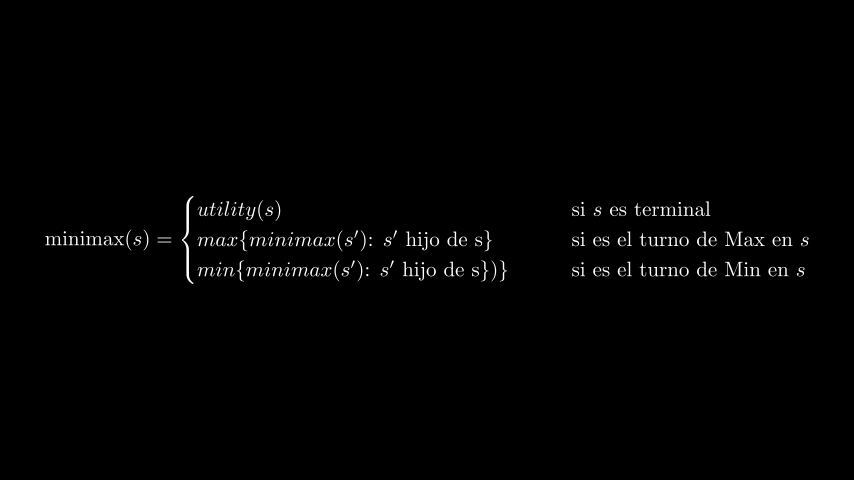

In [75]:
%%manim -ql TexTester

class TexTester(Scene):
    def construct(self):
        
        template = TexTemplate()
        template.add_to_preamble(r"\usepackage{amsmath}",
                                r"\usepackage{amssymb}")
        
        minimax_function = MathTex(r"\text{minimax($s$)} = ",
                                 r"""\begin{cases}
                                 utility(s) \qquad &\text{si $s$ es terminal} \cr
                                 max\{minimax(\text{$s'$): $s'$ hijo de }$s$\}\qquad &\text{si es el turno de Max en $s$} \cr
                                 min\{minimax(\text{$s'$): $s'$ hijo de }$s$\})\}\qquad &\text{si es el turno de Min en $s$} \cr
                                 \end{cases}""",
                                 tex_template=template).scale(0.7)
        
        self.add(minimax_function)